# Importing Labraries

In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as Plot
import pickle
from transformers import BertTokenizer, BertForNextSentencePrediction, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import functional as F
from transformers import AlbertTokenizer, AlbertModel
from transformers import DebertaTokenizer, DebertaModel


In [3]:
Data = pd.read_csv('database.csv')
Data

,case_id,docket_id,issues_id,vote_id,date_decision,decision_type,us_citation,court_citation,led_citation,lexis_citation,...,authority_decision_two,law_type,law_supplement,law_minor_supplement,majority_opinion_writer,majority_opinion_assigner,split_vote,majority_votes,minority_votes,Unnamed: 53
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,NaN,6.0,600.0,35 U.S.C. 33,78,78.0,1,8,1,NaN
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,NaN,6.0,600.0,18 U.S.C. 398,81,87.0,1,6,3,NaN
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,...,NaN,2.0,207.0,NaN,84,78.0,1,5,4,NaN
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,...,NaN,6.0,600.0,49 Stat. 801,87,87.0,1,5,3,NaN
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,...,NaN,NaN,NaN,NaN,78,87.0,1,6,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,2015-075,2015-075-01,2015-075-01-01,2015-075-01-01-01,6/27/2016,1,NaN,NaN,NaN,2016 U.S. LEXIS 4062,...,NaN,6.0,600.0,honest services wire fraud,111,111.0,1,8,0,NaN
8733,2015-076,2015-076-01,2015-076-01-01,2015-076-01-01-01,6/9/2016,1,NaN,NaN,195 L. Ed. 2d 161,2016 U.S. LEXIS 3772,...,NaN,9.0,900.0,NaN,113,111.0,1,6,2,NaN
8734,2015-077,2015-077-01,2015-077-01-01,2015-077-01-01-01,5/31/2016,2,NaN,136 S. Ct. 1818,195 L. Ed. 2d 99,2016 U.S. LEXIS 3487,...,7.0,2.0,230.0,NaN,NaN,111.0,1,6,2,NaN
8735,2015-078,2015-078-01,2015-078-01-01,2015-078-01-01-01,5/31/2016,2,NaN,136 S. Ct. 1802,195 L. Ed. 2d 92,2016 U.S. LEXIS 3488,...,3.0,9.0,900.0,NaN,NaN,111.0,1,8,0,NaN


In [4]:
# Printing The Data Columns
print(Data.columns)

Index(['case_id', 'docket_id', 'issues_id', 'vote_id', 'date_decision',
       'decision_type', 'us_citation', 'court_citation', 'led_citation',
       'lexis_citation', 'term', 'court', 'chief_justice', 'docket',
       'case_name', 'date_argument', 'date_reargument', 'petitioner',
       'petitioner_state', 'respondent', 'respondent_state', 'jurisdiction',
       'administrative_action', 'administrative_action_state',
       'district_court', 'case_origin', 'case_origin_state', 'case_source',
       'case_source_state', 'lower_court_disagreement', 'cert_reason',
       'lower_court_disposition', 'lower_disposition_direction',
       'declaration_unconstitutionality', 'case_disposition',
       'disposition_unusual', 'party_winning', 'precedent_alteration',
       'vote_unclear', 'issue', 'issue_area', 'decision_direction',
       'decision_direction_dissent', 'authority_decision_one',
       'authority_decision_two', 'law_type', 'law_supplement',
       'law_minor_supplement', 'major

In [5]:
Data['case_name'] = Data['case_name'].str.replace('@', ' ')


Creating Term Frequency - Inverse Document Frequency

In [6]:
TFIDFML = TfidfVectorizer()
TFIDFML.fit(Data.case_name)
# Creating TF-IDF Dicitonary
Dictionary = dict(zip(TFIDFML.get_feature_names(), list(TFIDFML.idf_)))
# Defining Feature Name
TFIDFfeature = TFIDFML.get_feature_names()
for term, idf_value in Dictionary.items(): # Printing The Dictonary
    print(f'Term: {term}, IDF Value: {idf_value}')
print(TFIDFML.fit)
print(TFIDFfeature)


Term: 011, IDF Value: 9.382289428951436
Term: 10, IDF Value: 9.382289428951436
Term: 100, IDF Value: 8.97682432084327
Term: 1000, IDF Value: 9.382289428951436
Term: 1001, IDF Value: 9.382289428951436
Term: 1029, IDF Value: 9.382289428951436
Term: 103, IDF Value: 9.382289428951436
Term: 104, IDF Value: 9.382289428951436
Term: 107, IDF Value: 9.382289428951436
Term: 11, IDF Value: 8.68914224839149
Term: 112, IDF Value: 9.382289428951436
Term: 114, IDF Value: 9.382289428951436
Term: 1182, IDF Value: 9.382289428951436
Term: 12, IDF Value: 8.97682432084327
Term: 1212, IDF Value: 9.382289428951436
Term: 1229, IDF Value: 9.382289428951436
Term: 125, IDF Value: 9.382289428951436
Term: 1263, IDF Value: 9.382289428951436
Term: 1264, IDF Value: 9.382289428951436
Term: 128, IDF Value: 9.382289428951436
Term: 1285, IDF Value: 9.382289428951436
Term: 1287, IDF Value: 9.382289428951436
Term: 1291, IDF Value: 9.382289428951436
Term: 13, IDF Value: 9.382289428951436
Term: 1309, IDF Value: 9.38228942895

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


 Removing Punctuation,
 Spaces,
 Sentence Segment
 and turning into list


In [7]:
def PreProcess(Text):
    # Remove punctuation, spaces, and unwanted characters
    Rule = re.compile(r'[^a-zA-Z0-9\u4e00-\u9fa5]')
    Text = Rule.sub(' ', str(Text))
    Text = re.sub(' +', ' ', Text)

    # Split the text into words (tokenization) and return as a list
    Text = Text.split()  # Split text into words based on spaces

    return Text


# Implementing Word2Vec

In [8]:
# Implementing Data Sclicing Procedure With Respect To 1000 Samples
SubsetSize = 1000  
SubsetData = Data.head(SubsetSize).copy()  

# Training the Word2Vec model on the basis of the corresponding subset
SubsetSentences = SubsetData['case_name'].tolist()
SubsetSentences = [PreProcess(text) for text in SubsetSentences]

Model = Word2Vec(
    SubsetSentences,
    vector_size=100,
    window=5,
    min_count=1,
    sg=0
)

# Incorporating TF-IDF information into Word2Vec word vectors
for Word in Model.wv.index_to_key:
    WordVector = Model.wv[Word]
    if Word in Dictionary:
        TFIDFWeight = Dictionary[Word]
        WeightedVector = WordVector * TFIDFWeight
        Model.wv[Word] = WeightedVector

# Saving the Word2Vec model
Model.save("word2vec_with_tfidf_1000samples.model")
# Printing the data details
print(len(Data))
print(len(SubsetSentences))

# Loading the Word2Vec model with TF-IDF weighting
Word2VecModel = Word2Vec.load("word2vec_with_tfidf_1000samples.model")


8737
1000


In [9]:
# Implementing recommendation engine 
def recommend_law(Text, Data, model=Word2VecModel):
    # Tokenizing and preprocessing the input text
    Text = PreProcess(Text)

    # Initializing variables to store Similarities and recommended laws
    Similarities = []
    RecommendedLaws = []

    for _, row in Data.iterrows():
        # Tokenizing and preprocessing the legal texts in your dataset
        LegalText = PreProcess(row['case_name'])

        # Calculating the Similarity between the input text and legal text
        Similarity = 0  # Initializing Similarity score to 0
        Count = 0  # Initializing a Count to keep track of common words

        for Word in Text:
            if Word in model.wv and Word in LegalText:
                Similarity += model.wv.n_similarity([Word], LegalText)
                Count += 1

        if Count > 0:
            Similarity /= Count  # Calculating the Average Similarity scores

        # Saving the Similarity score and corresponding legal text
        Similarities.append(Similarity)
        RecommendedLaws.append(row['case_name'])

    # Combining the Similarities and recommended laws into a DataFrame
    Recommendationdf = pd.DataFrame({'Legal Text': RecommendedLaws, 'Similarity': Similarities})

    # Sorting the DataFrame by Similarity in descending order
    Recommendationdf = Recommendationdf.sort_values(by='Similarity', ascending=False)

    # Returning the top recommended laws
    TopRecommendations = Recommendationdf.head(20)

    return TopRecommendations


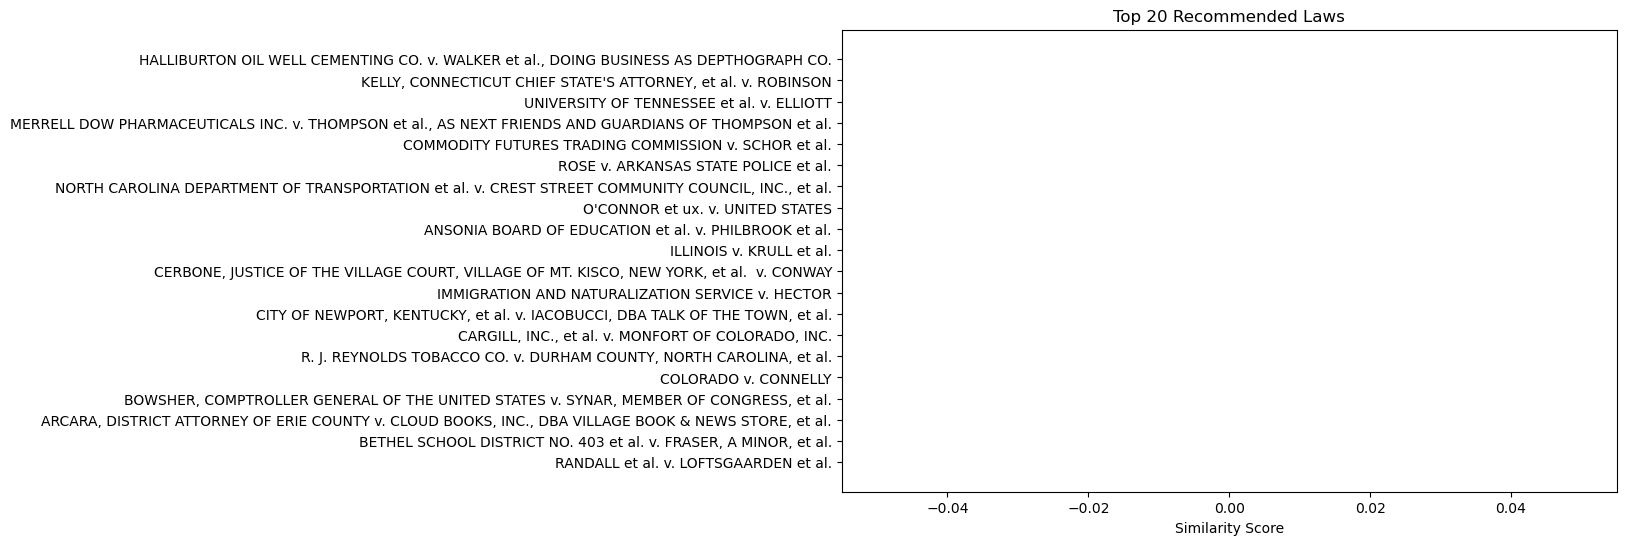

In [10]:
# Printing the Recommendations with respect to graphical representation of similarity ratio
def plot_recommendations(Recommendations):
    # Plotting
    Plot.figure(figsize=(10, 6))
    Plot.barh(Recommendations['Legal Text'], Recommendations['Similarity'], color='orange')
    Plot.xlabel('Similarity Score')
    Plot.title('Top 20 Recommended Laws')
    Plot.gca().invert_yaxis()  # Inverting y-axis to calculating the highest similarity at the top
    Plot.show()

# Experimenting by entering input text
InputText = "United States"
TopRecommendations = recommend_law(InputText, Data, model=Word2VecModel)
plot_recommendations(TopRecommendations)


Mean Similarity Score: 0.0


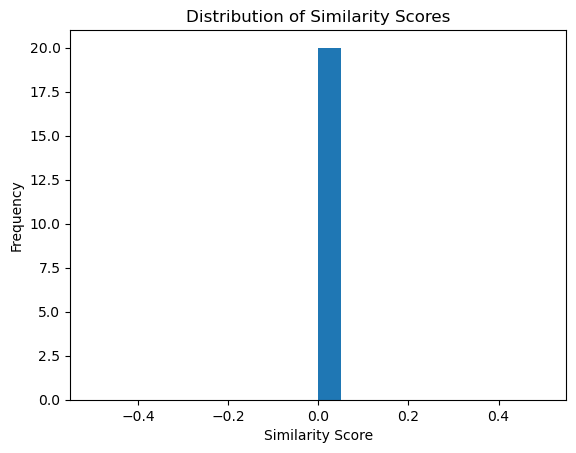

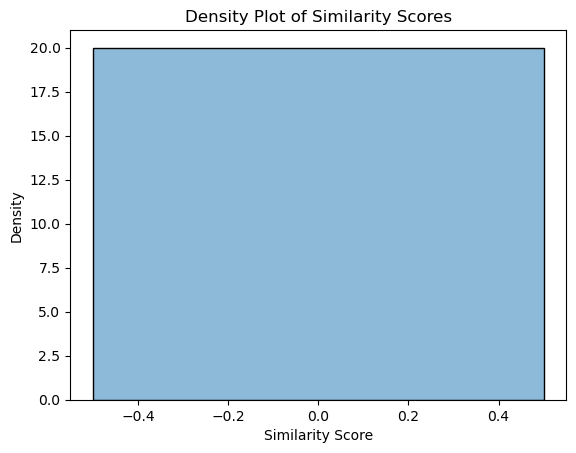

In [11]:
# Calculating Mean Similarity Score with respect to recommendations
MeanSimilarity = TopRecommendations['Similarity'].mean()
print(f"Mean Similarity Score: {MeanSimilarity}")

# Displaying a histogram of similarity scores with respect to recommendations
Plot.hist(TopRecommendations['Similarity'], bins=20)
Plot.xlabel('Similarity Score')
Plot.ylabel('Frequency')
Plot.title('Distribution of Similarity Scores')
Plot.show()

# Displaying a histogram of Density of similarity scores with respect to recommendations
sns.histplot(TopRecommendations['Similarity'], kde=True)
Plot.xlabel('Similarity Score')
Plot.ylabel('Density')
Plot.title('Density Plot of Similarity Scores')
Plot.show()



Results of Implementation of Word2Vec Model With respect to 1000 samples

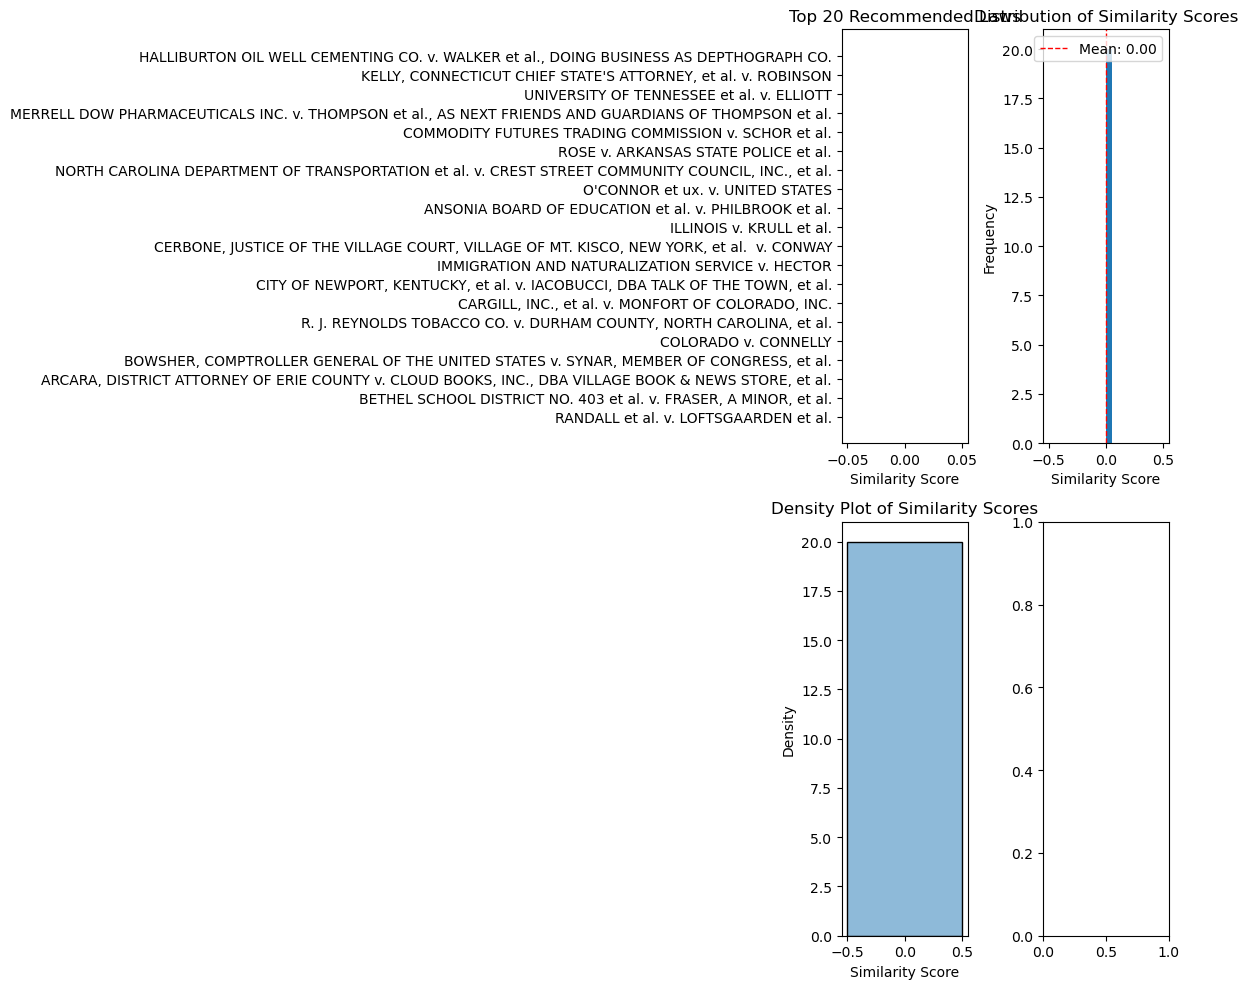

In [12]:

def plot_recommendations(Recommendations):
    # Plotting recommendations
    fig, axes = Plot.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Plotting the bar plot for recommendations
    Axes1 = axes[0, 0]
    Axes1.barh(Recommendations['Legal Text'], Recommendations['Similarity'], color='orange')
    Axes1.set_xlabel('Similarity Score')
    Axes1.set_title('Top 20 Recommended Laws')
    Axes1.invert_yaxis()

    # Calculating mean similarity
    MeanSimilarity = Recommendations['Similarity'].mean()

    # Plotting the histogram
    Axes2 = axes[0, 1]
    Axes2.hist(Recommendations['Similarity'], bins=20)
    Axes2.set_xlabel('Similarity Score')
    Axes2.set_ylabel('Frequency')
    Axes2.set_title('Distribution of Similarity Scores')
    Axes2.axvline(MeanSimilarity, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {MeanSimilarity:.2f}")
    Axes2.legend()

    # Plotting the density plot
    Axes3 = axes[1, 0:2]
    sns.histplot(Recommendations['Similarity'], kde=True, ax=Axes3[0])
    Axes3[0].set_xlabel('Similarity Score')
    Axes3[0].set_ylabel('Density')
    Axes3[0].set_title('Density Plot of Similarity Scores')

    Plot.tight_layout()
    Plot.show()

InputText = "United States"
TopRecommendations = recommend_law(InputText, Data, model=Word2VecModel)
plot_recommendations(TopRecommendations)



# Implementing BERT

In [13]:

# Implementing Data Sclicing Procedure With Respect To 1000 Samples
SubsetSize = 1000 

SmallerSubset = Data.head(SubsetSize).copy() 

Corpus = SmallerSubset['case_name'].tolist()

# Preprocessing the corpus and feature names for TF-IDF
Corpus = [text.lower() for text in Corpus]  # Converting text to lowercase for consistency

# Initializing a BERT tokenizer and model
Tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertModel = BertModel.from_pretrained('bert-base-uncased')

# Tokenizing and getting BERT embeddings in smaller batches
BatchSize = 32 
MaxLength = 128 
EmbeddingsList = []


# Implementing the Helper function for processing a batch and for obtaining BERT embeddings
def process_batch(BatchTexts):
    # Preprocessing batch texts to lowercase
    BatchTexts = [text.lower() for text in BatchTexts]

    inputs = Tokenizer(
        BatchTexts,
        return_tensors='pt',
        padding='max_length',  
        max_length=MaxLength,  
        truncation=True
    )
    with torch.no_grad():
        BatchEmbeddings = BertModel(**inputs).last_hidden_state

    return BatchEmbeddings


for i in range(0, len(Corpus), BatchSize):
    BatchTexts = Corpus[i:i + BatchSize]
    BatchEmbeddings = process_batch(BatchTexts)
    EmbeddingsList.append(BatchEmbeddings)

# Concatenating embeddings from different batches for the smaller subset
Embeddings = torch.cat(EmbeddingsList, dim=0)

# Printing the data details
print(len(Data))
print(len(Embeddings))


8737
1000


In [14]:
# Implementing recommendation engine 
def recommend_law(Text, Data, Embeddings):
    Similarities = []
    RecommendedLaws = []
    AverageSimilarities = []

    # Tokenizing and preprocessing the input text
    Text = Text.lower()
    inputs1 = Tokenizer(
        [Text],
        return_tensors='pt',
        padding='max_length',
        max_length=MaxLength,
        truncation=True
    )
    with torch.no_grad():
        Embeddings1 = BertModel(**inputs1).last_hidden_state

    for i in range(len(Embeddings)):
        LegalText = Data['case_name'].iloc[i].lower()
        inputs2 = Tokenizer(
            [LegalText],
            return_tensors='pt',
            padding='max_length',
            max_length=MaxLength,
            truncation=True
        )
        with torch.no_grad():
            Embeddings2 = Embeddings[i]  # Utilizing the precomputed DeBERTa embeddings for the smaller subset

        # Calculating cosine similarity between embeddings
        similarity = torch.nn.functional.cosine_similarity(Embeddings1, Embeddings2, dim=1).max().item()

        Similarities.append(similarity)
        RecommendedLaws.append(Data['case_name'].iloc[i])
        # Calculating average similarity for each interaction
        AverageSimilarity = np.mean(Similarities)
        AverageSimilarities.append(AverageSimilarity)
    Recommendationdf = pd.DataFrame({'Legal Text': RecommendedLaws, 'Similarity1': Similarities})
    Recommendationdf = Recommendationdf.sort_values(by='Similarity1', ascending=False)
    TopRecommendations = Recommendationdf.head(20)

    return TopRecommendations, AverageSimilarities



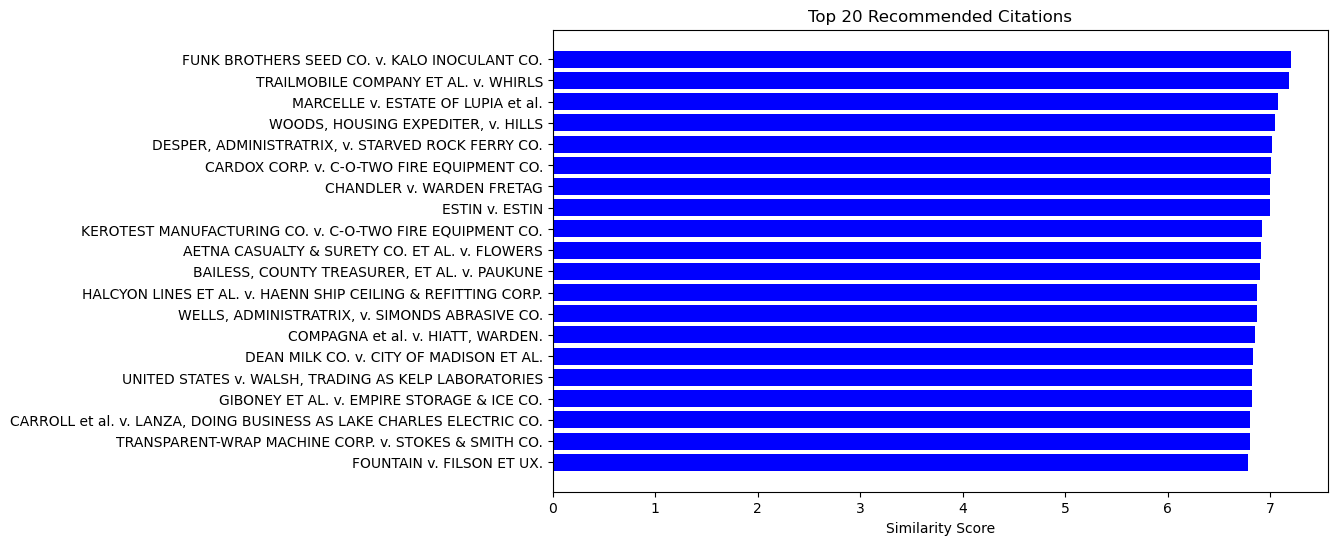

In [15]:
# Printing the Recommendations with respect to graphical representation of similarity ratio
def plot_recommendations(Recommendations):
    # Plotting
    Plot.figure(figsize=(10, 6))
    Plot.barh(Recommendations[0]['Legal Text'], Recommendations[0]['Similarity1'], color='blue')
    Plot.xlabel('Similarity Score')
    Plot.title('Top 20 Recommended Citations')
    Plot.gca().invert_yaxis()  # Inverting y-axis to have the highest similarity at the top
    Plot.show()

# Experimenting by entering input text
InputText = "United States"
TopRecommendations = recommend_law(InputText, Data, Embeddings)
plot_recommendations(TopRecommendations)



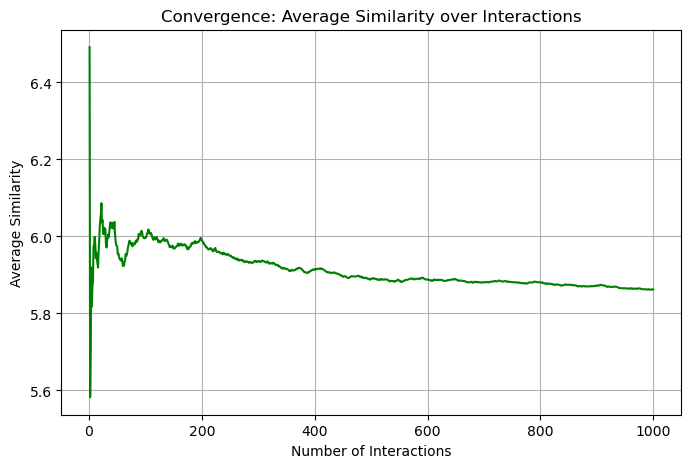

In [16]:
# Representating Average Similarity Scores With Respect to 1000 Iteractions
TopRecommendations, AvgSimilarities = recommend_law(InputText, SmallerSubset, Embeddings)

# Converting smaller_subset to numpy array or list
SmallerSubsetArray = SmallerSubset['case_name'].values.tolist()

# Plotting convergence metrics
Interactions = np.arange(1, len(AvgSimilarities) + 1)
Plot.figure(figsize=(8, 5))
Plot.plot(Interactions, AvgSimilarities, color='green')
Plot.title('Convergence: Average Similarity over Interactions')
Plot.xlabel('Number of Interactions')
Plot.ylabel('Average Similarity')
Plot.grid(True)
Plot.show()



Mean Similarity Score: 6.936242198944091


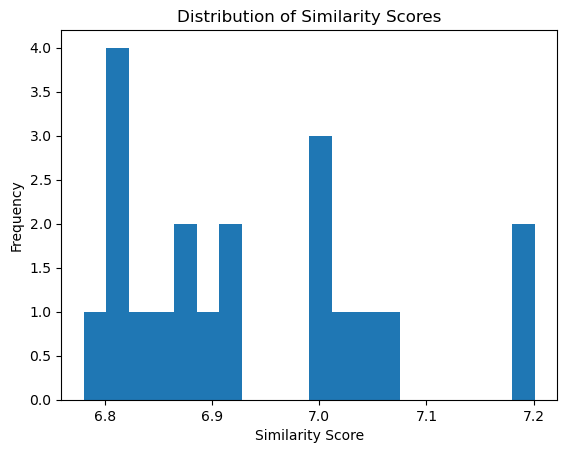

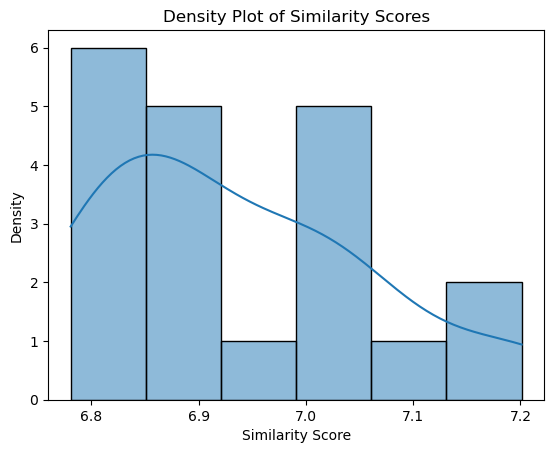

In [17]:
# Calculating Mean Similarity Score with respect to recommendations
MeanSimilarity = TopRecommendations['Similarity1'].mean()
print(f"Mean Similarity Score: {MeanSimilarity}")

# Displaying a histogram of similarity scores
Plot.hist(TopRecommendations['Similarity1'], bins=20)
Plot.xlabel('Similarity Score')
Plot.ylabel('Frequency')
Plot.title('Distribution of Similarity Scores')
Plot.show()

# Displaying a histogram of Density of similarity scores with respect to recommendations
sns.histplot(TopRecommendations['Similarity1'], kde=True)
Plot.xlabel('Similarity Score')
Plot.ylabel('Density')
Plot.title('Density Plot of Similarity Scores')
Plot.show()


Results of Implementation of BERT Model With respect to 1000 samples

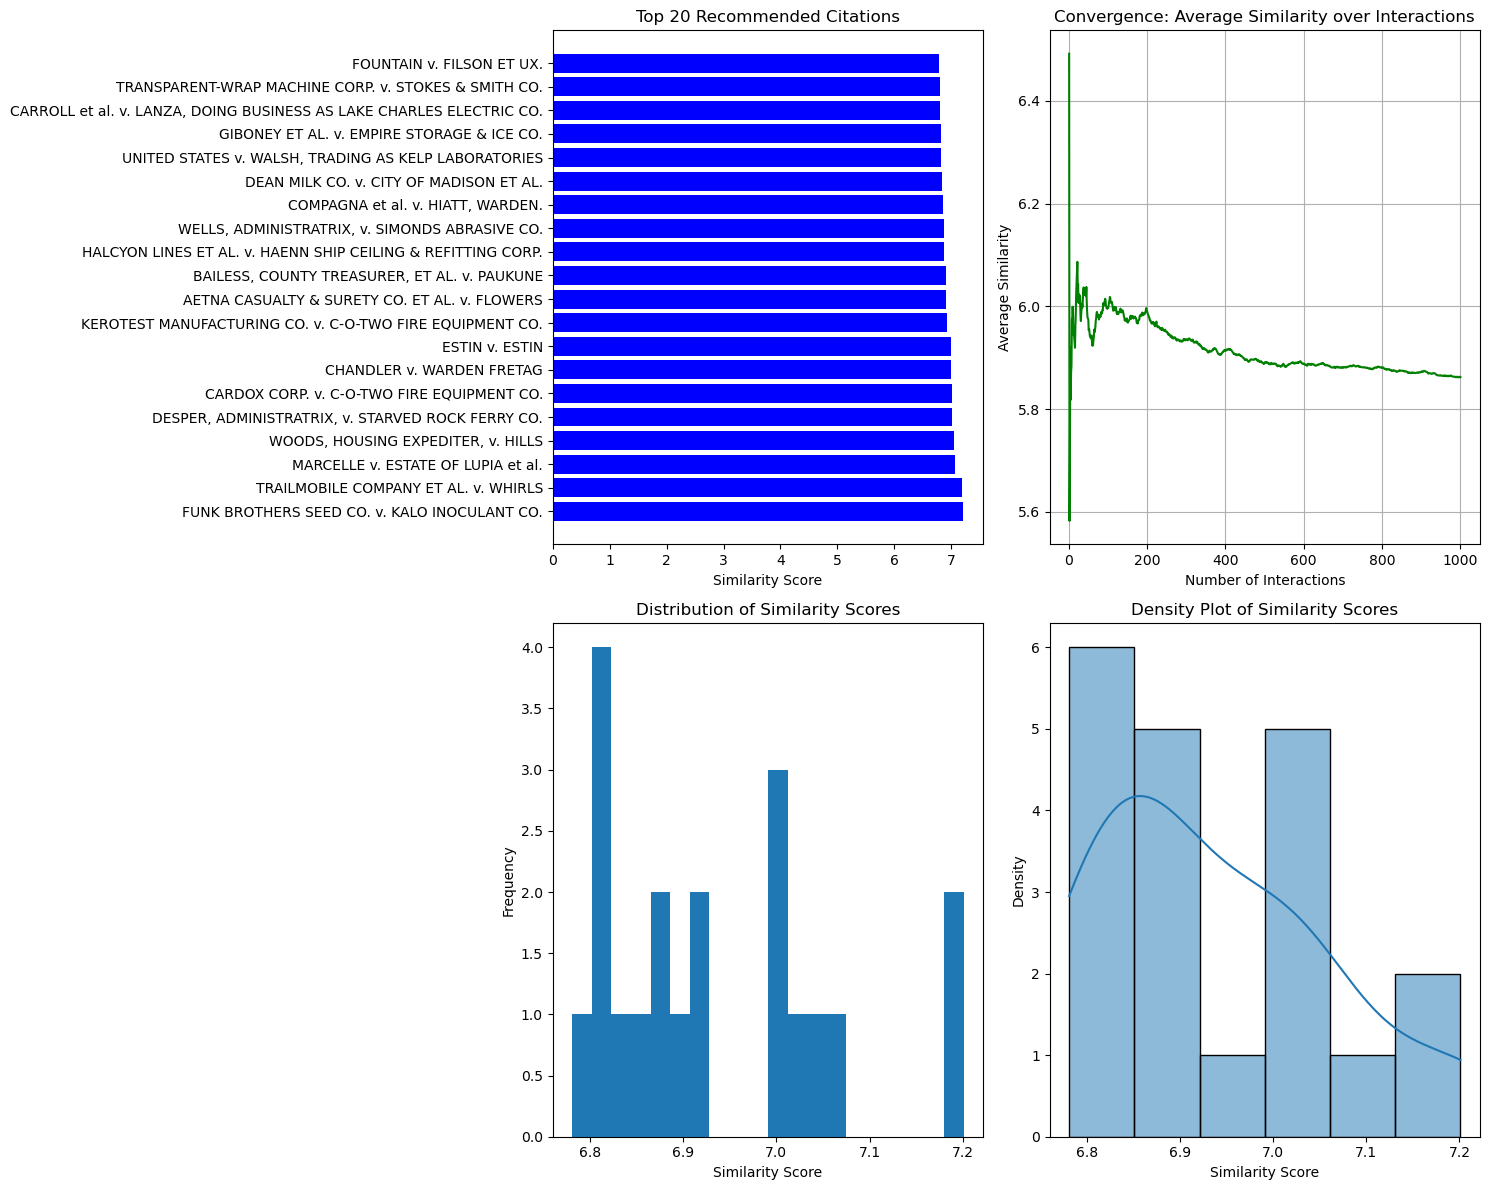

In [18]:


def plot_recommendations(Recommendations):
    # Unpacking the tuple of recommendations and average similarities
    TopRecommendations, AvgSimilarities = Recommendations

    # Creating a 2x2 grid of subplots
    fig, axes = Plot.subplots(2, 2, figsize=(15, 12))

    # Plotting the bar plot for recommendations
    Axes1 = axes[0, 0]
    Axes1.barh(TopRecommendations['Legal Text'], TopRecommendations['Similarity1'], color='blue')
    Axes1.set_xlabel('Similarity Score')
    Axes1.set_title('Top 20 Recommended Citations')

    # Plotting the convergence metrics
    Axes2 = axes[0, 1]
    interactions = range(1, len(AvgSimilarities) + 1)
    Axes2.plot(interactions, AvgSimilarities, color='green')
    Axes2.set_title('Convergence: Average Similarity over Interactions')
    Axes2.set_xlabel('Number of Interactions')
    Axes2.set_ylabel('Average Similarity')
    Axes2.grid(True)

    # Plotting the histogram of similarity scores
    Axes3 = axes[1, 0]
    Axes3.hist(TopRecommendations['Similarity1'], bins=20)
    Axes3.set_xlabel('Similarity Score')
    Axes3.set_ylabel('Frequency')
    Axes3.set_title('Distribution of Similarity Scores')

    # Plotting the density plot of similarity scores
    Axes4 = axes[1, 1]
    sns.histplot(TopRecommendations['Similarity1'], kde=True, ax=Axes4)
    Axes4.set_xlabel('Similarity Score')
    Axes4.set_ylabel('Density')
    Axes4.set_title('Density Plot of Similarity Scores')

    # Adjusting layout and displaying plots
    Plot.tight_layout()
    Plot.show()

InputText = "United States"
TopRecommendations, AvgSimilarities = recommend_law(InputText, Data, Embeddings)
plot_recommendations((TopRecommendations, AvgSimilarities))



# Implementing ALBERT

In [19]:
# Implementing Data Sclicing Procedure With Respect To 1000 Samples

SubsetSize = 1000  

SmallerSubset = Data.head(SubsetSize).copy()  

Corpus = SmallerSubset['case_name'].tolist()

# Preprocessing the corpus for TF-IDF
Corpus = [text.lower() for text in Corpus]  # Convert text to lowercase for consistency

# Initializing an ALBERT tokenizer and model
Tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
AlbertModel = AlbertModel.from_pretrained('albert-base-v2')

# Tokenizing and getting ALBERT embeddings in smaller batches
BatchSize = 32  # You can adjust this as needed
MaxLength = 128  # You can adjust this as needed
EmbeddingsList = []


# Implementing Helper function to process a batch and obtain ALBERT embeddings
def process_batch(BatchTexts):
    # Preprocessing batch texts to lowercase
    BatchTexts = [text.lower() for text in BatchTexts]

    inputs = Tokenizer(
        BatchTexts,
        return_tensors='pt',
        padding='max_length', 
        max_length=MaxLength,  
        truncation=True
    )
    with torch.no_grad():
        BatchOutputs = AlbertModel(**inputs)
        BatchEmbeddings = BatchOutputs.last_hidden_state

    return BatchEmbeddings


for i in range(0, len(Corpus), BatchSize):
    BatchTexts = Corpus[i:i + BatchSize]
    BatchEmbeddings = process_batch(BatchTexts)
    EmbeddingsList.append(BatchEmbeddings)

# Concatenating embeddings from different batches for the smaller subset
Embeddings = torch.cat(EmbeddingsList, dim=0)

# Printing the data details
print(len(Data))
print(len(Embeddings))



8737
1000


In [20]:
# Implementing recommendation engine 
def Recommend_Laws(Text, Data, Embeddings):
    Similarities = []
    RecommendedLaws = []
    AverageSimilarities = []

    # Tokenizing and preprocess the input text
    Text = Text.lower()
    inputs1 = Tokenizer(
        [Text],
        return_tensors='pt',
        padding='max_length',
        max_length=MaxLength,
        truncation=True
    )
    with torch.no_grad():
        Embeddings1 = AlbertModel(**inputs1).last_hidden_state

    for i in range(len(Embeddings)):
        LegalText = Data['case_name'].iloc[i].lower()
        inputs2 = Tokenizer(
            [LegalText],
            return_tensors='pt',
            padding='max_length',
            max_length=MaxLength,
            truncation=True
        )
        with torch.no_grad():
            Embeddings2 = Embeddings[i]  # Use the precomputed DeBERTa embeddings for the smaller subset

        # Calculating cosine similarity between embeddings
        Similarity = torch.nn.functional.cosine_similarity(Embeddings1, Embeddings2, dim=1).max().item()

        Similarities.append(Similarity)
        RecommendedLaws.append(Data['case_name'].iloc[i])
        # Calculating average similarity for each interaction
        AverageSimilarity = np.mean(Similarities)
        AverageSimilarities.append(AverageSimilarity)
    Recommendationdf = pd.DataFrame({'Legal Text': RecommendedLaws, 'Similarity2': Similarities})
    Recommendationdf = Recommendationdf.sort_values(by='Similarity2', ascending=False)
    TopRecommendations = Recommendationdf.head(20)

    return TopRecommendations, AverageSimilarities



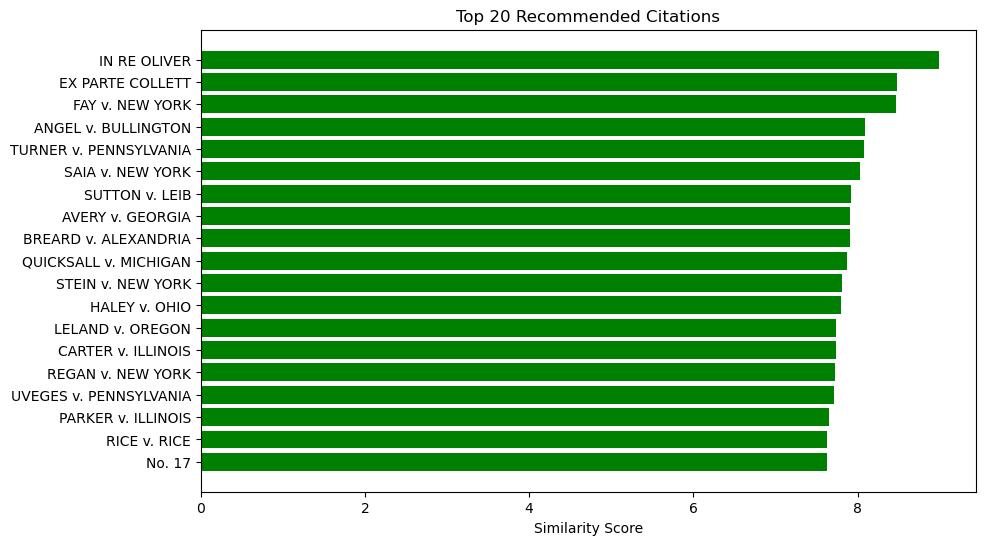

In [21]:
# Printing the Recommendations with respect to graphical representation of similarity ratio
def plot_recommendations(Recommendations):
    # Plotting
    Plot.figure(figsize=(10, 6))
    Plot.barh(Recommendations[0]['Legal Text'], Recommendations[0]['Similarity2'], color='green')
    Plot.xlabel('Similarity Score')
    Plot.title('Top 20 Recommended Citations')
    Plot.gca().invert_yaxis()  # Inverting y-axis to have the highest similarity at the top
    Plot.show()

# Experimenting by entering input text
InputText = "United States"
TopRecommendations = Recommend_Laws(InputText, Data, Embeddings)
plot_recommendations(TopRecommendations)



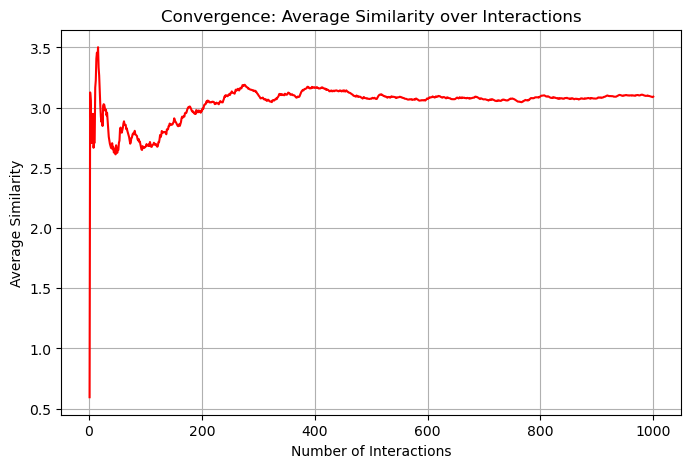

In [22]:
# Representating Average Similarity Scores With Respect to 1000 Iteractions
TopRecommendations, AvgSimilarities = Recommend_Laws(InputText, SmallerSubset, Embeddings)

# Converting smaller_subset to numpy array or list
SmallerSubsetArray = SmallerSubset['case_name'].values.tolist()

# Plotting convergence metrics
Interactions = np.arange(1, len(AvgSimilarities) + 1)
Plot.figure(figsize=(8, 5))
Plot.plot(Interactions, AvgSimilarities, color='red')
Plot.title('Convergence: Average Similarity over Interactions')
Plot.xlabel('Number of Interactions')
Plot.ylabel('Average Similarity')
Plot.grid(True)
Plot.show()



Mean Similarity Score: 7.9408657312393185


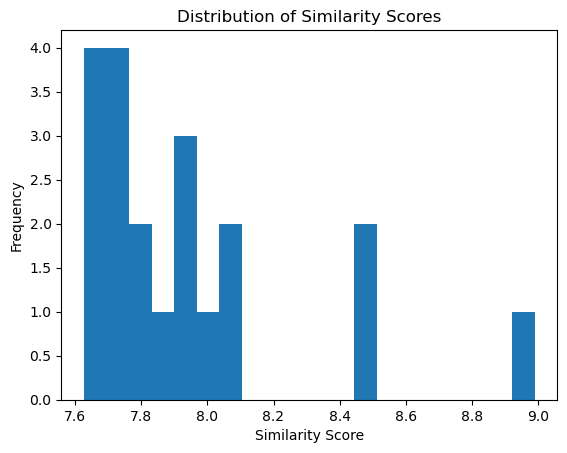

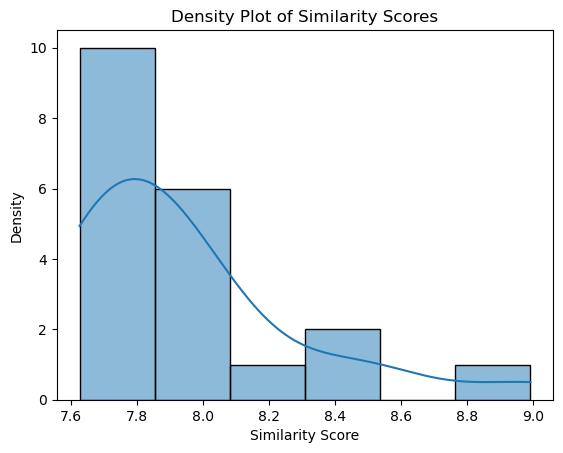

In [23]:
# Calculating Mean Similarity Score with respect to recommendations
MeanSimilarity = TopRecommendations['Similarity2'].mean()
print(f"Mean Similarity Score: {MeanSimilarity}")

# Displaying a histogram of similarity scores
Plot.hist(TopRecommendations['Similarity2'], bins=20)
Plot.xlabel('Similarity Score')
Plot.ylabel('Frequency')
Plot.title('Distribution of Similarity Scores')
Plot.show()

# Displaying a histogram of Density of similarity scores with respect to recommendations
sns.histplot(TopRecommendations['Similarity2'], kde=True)
Plot.xlabel('Similarity Score')
Plot.ylabel('Density')
Plot.title('Density Plot of Similarity Scores')
Plot.show()


Results of Implementation of ALBERT Model With respect to 1000 samples

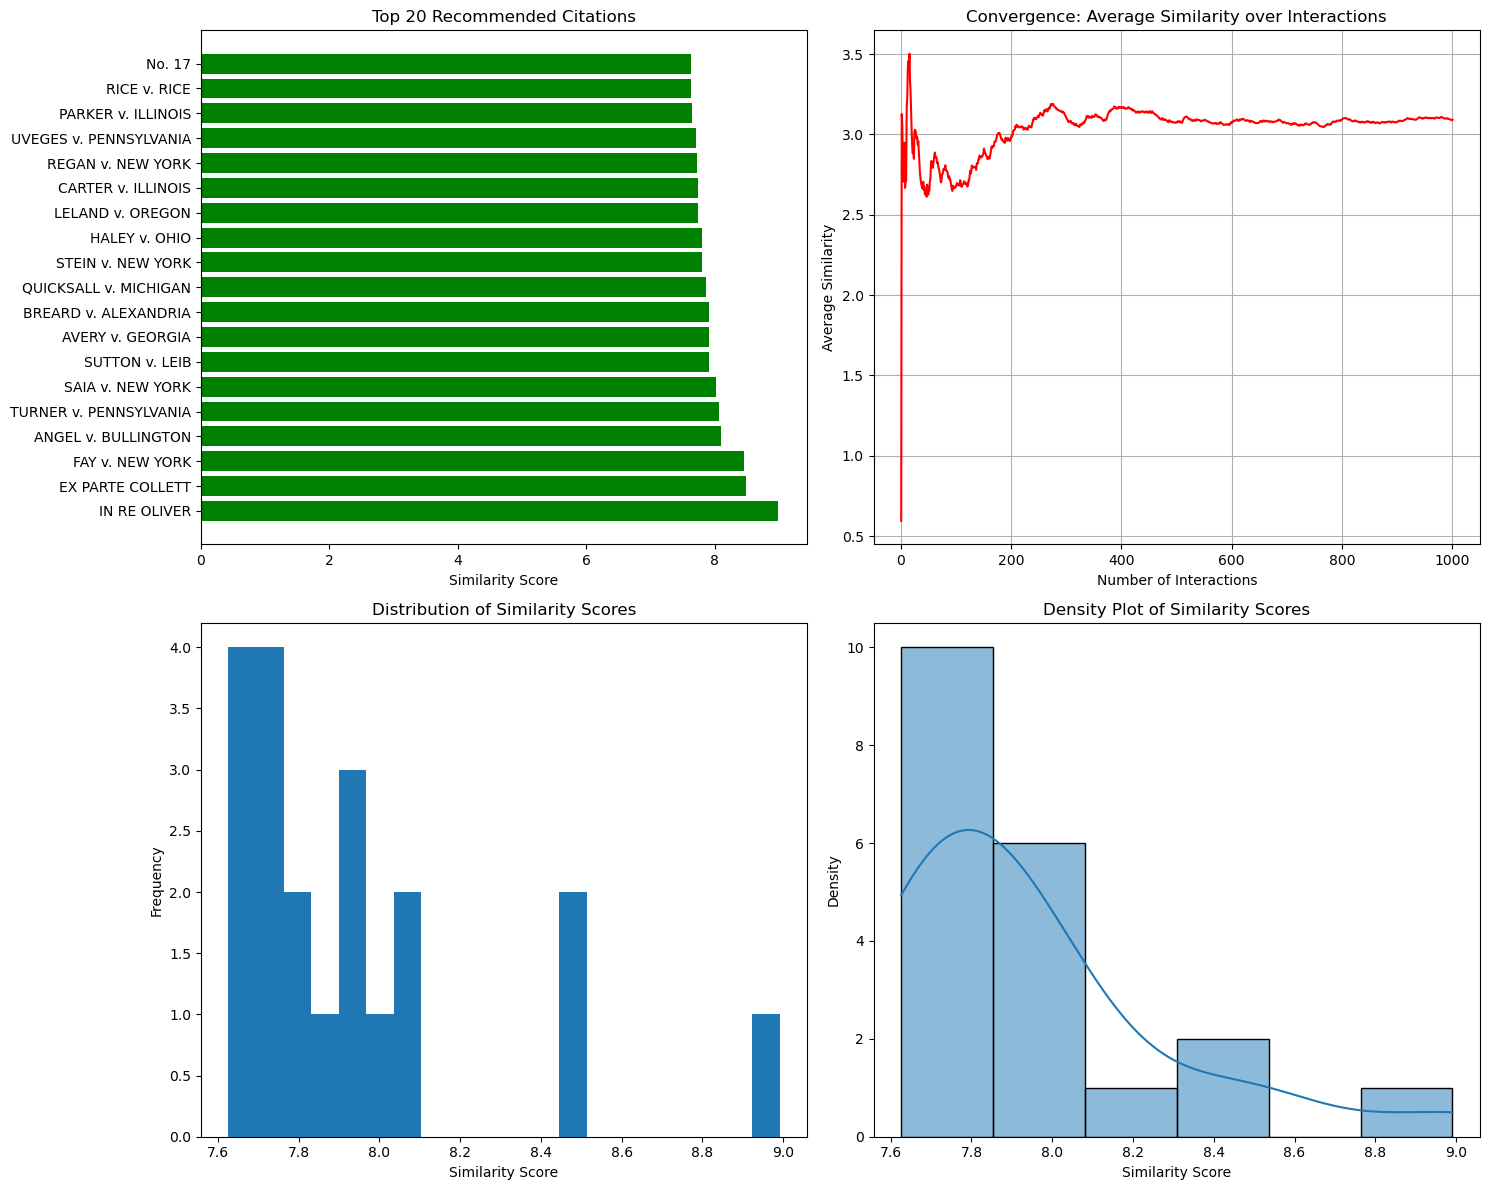

In [24]:

def plot_recommendations(Recommendations):
    # Unpacking the tuple of recommendations and average similarities
    TopRecommendations, AvgSimilarities = Recommendations

    # Creating a 2x2 grid of subplots
    fig, axes = Plot.subplots(2, 2, figsize=(15, 12))

    # Plotting the bar plot for recommendations
    Axes1 = axes[0, 0]
    Axes1.barh(TopRecommendations['Legal Text'], TopRecommendations['Similarity2'], color='green')
    Axes1.set_xlabel('Similarity Score')
    Axes1.set_title('Top 20 Recommended Citations')

    # Plotting the convergence metrics
    Axes2 = axes[0, 1]
    interactions = range(1, len(AvgSimilarities) + 1)
    Axes2.plot(interactions, AvgSimilarities, color='red')
    Axes2.set_title('Convergence: Average Similarity over Interactions')
    Axes2.set_xlabel('Number of Interactions')
    Axes2.set_ylabel('Average Similarity')
    Axes2.grid(True)

    # Plotting the histogram of similarity scores
    Axes3 = axes[1, 0]
    Axes3.hist(TopRecommendations['Similarity2'], bins=20)
    Axes3.set_xlabel('Similarity Score')
    Axes3.set_ylabel('Frequency')
    Axes3.set_title('Distribution of Similarity Scores')

    # Plotting the density plot of similarity scores
    Axes4 = axes[1, 1]
    sns.histplot(TopRecommendations['Similarity2'], kde=True, ax=Axes4)
    Axes4.set_xlabel('Similarity Score')
    Axes4.set_ylabel('Density')
    Axes4.set_title('Density Plot of Similarity Scores')

    # Adjusting layout and display plots
    Plot.tight_layout()
    Plot.show()

InputText = "United States"
TopRecommendations, AvgSimilarities = Recommend_Laws(InputText, Data, Embeddings)
plot_recommendations((TopRecommendations, AvgSimilarities))


# Implementing DeBERTa

In [25]:
# Implementing Data Sclicing Procedure With Respect To 1000 Samples

SubsetSize = 1000  

SmallerSubset = Data.head(SubsetSize).copy() 

Corpus = SmallerSubset['case_name'].tolist()

# Preprocessing the corpus for TF-IDF
Corpus = [text.lower() for text in Corpus]  # Convert text to lowercase for consistency

# Initializing a DeBERTa tokenizer and model
Tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
DebertaModel = DebertaModel.from_pretrained('microsoft/deberta-base')

# Tokenizing and getting DeBERTa embeddings in smaller batches
BatchSize = 32  # You can adjust this as needed
MaxLength = 128  # You can adjust this as needed
EmbeddingsList = []


# Implementing Helper function to process a batch and obtain DeBERTa embeddings
def process_batch(BatchTexts):
    # Preprocessing batch texts to lowercase
    BatchTexts = [text.lower() for text in BatchTexts]

    inputs = Tokenizer(
        BatchTexts,
        return_tensors='pt',
        padding='max_length',  
        max_length=MaxLength,  
        truncation=True
    )
    with torch.no_grad():
        BatchOutputs = DebertaModel(**inputs)
        BatchEmbeddings = BatchOutputs.last_hidden_state

    return BatchEmbeddings


for i in range(0, len(Corpus), BatchSize):
    BatchTexts = Corpus[i:i + BatchSize]
    BatchEmbeddings = process_batch(BatchTexts)
    EmbeddingsList.append(BatchEmbeddings)

# Concatenating embeddings from different batches for the smaller subset
Embeddings = torch.cat(EmbeddingsList, dim=0)

# Printing the data details
print(len(Data))
print(len(Embeddings))


8737
1000


In [26]:
# Implementing recommendation engine 
def RecommendLaw(Text, Data, Embeddings):
    Similarities = []
    RecommendedLaws = []
    AverageSimilarities = []

    # Tokenizing and preprocessing the input text
    Text = Text.lower()
    inputs1 = Tokenizer(
        [Text],
        return_tensors='pt',
        padding='max_length',
        max_length=MaxLength,
        truncation=True
    )
    with torch.no_grad():
        Embeddings1 = DebertaModel(**inputs1).last_hidden_state

    for i in range(len(Embeddings)):
        LegalText = Data['case_name'].iloc[i].lower()
        inputs2 = Tokenizer(
            [LegalText],
            return_tensors='pt',
            padding='max_length',
            max_length=MaxLength,
            truncation=True
        )
        with torch.no_grad():
            Embeddings2 = Embeddings[i]  # Utilizing the precomputed DeBERTa embeddings for the smaller subset

        # Calculating cosine similarity between embeddings
        Similarity = torch.nn.functional.cosine_similarity(Embeddings1, Embeddings2, dim=1).max().item()

        Similarities.append(Similarity)
        RecommendedLaws.append(Data['case_name'].iloc[i])
        # Calculating average similarity for each interaction
        AverageSimilarity = np.mean(Similarities)
        AverageSimilarities.append(AverageSimilarity)
    Recommendationdf = pd.DataFrame({'Legal Text': RecommendedLaws, 'Similarity3': Similarities})
    Recommendationdf = Recommendationdf.sort_values(by='Similarity3', ascending=False)
    TopRecommendations = Recommendationdf.head(20)

    return TopRecommendations, AverageSimilarities


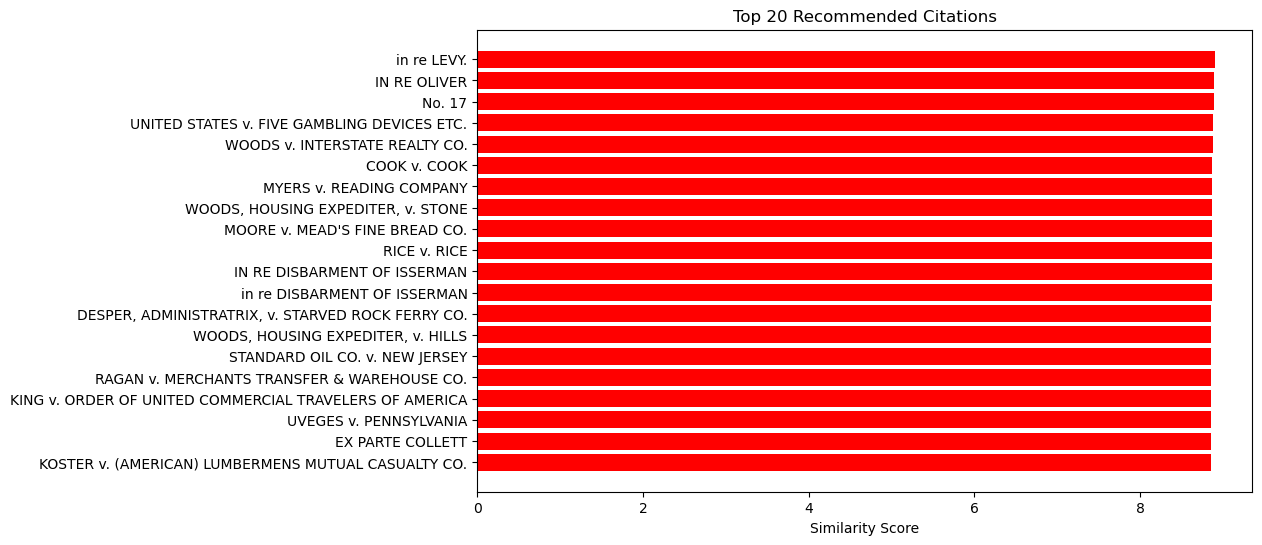

In [27]:
# Printing the Recommendations with respect to graphical representation of similarity ratio
def plot_recommendations(Recommendations):
    # Plotting
    Plot.figure(figsize=(10, 6))
    Plot.barh(Recommendations[0]['Legal Text'], Recommendations[0]['Similarity3'], color='red')
    Plot.xlabel('Similarity Score')
    Plot.title('Top 20 Recommended Citations')
    Plot.gca().invert_yaxis()  # Inverting y-axis to have the highest similarity at the top
    Plot.show()

# Experimenting by entering input text
InputText = "United States"
TopRecommendations = RecommendLaw(InputText, Data, Embeddings)
plot_recommendations(TopRecommendations)



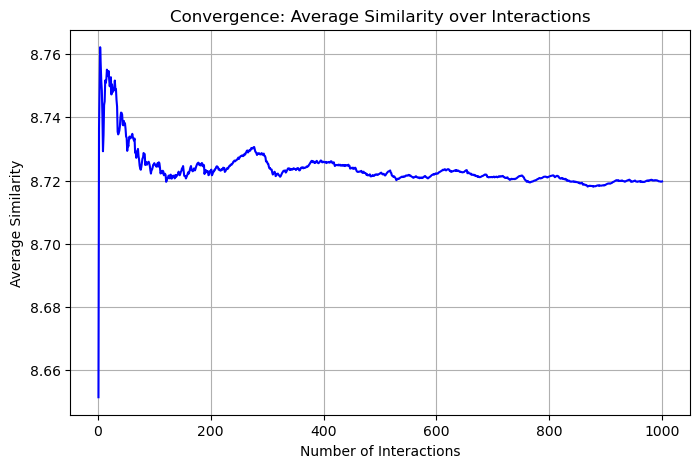

In [28]:
# Representating Average Similarity Scores With Respect to 1000 Iteractions
TopRecommendations, AvgSimilarities = RecommendLaw(InputText, SmallerSubset, Embeddings)

# Converting smaller_subset to numpy array or list
SmallerSubsetArray = SmallerSubset['case_name'].values.tolist()

# Plotting convergence metrics
Interactions = np.arange(1, len(AvgSimilarities) + 1)
Plot.figure(figsize=(8, 5))
Plot.plot(Interactions, AvgSimilarities, color='blue')
Plot.title('Convergence: Average Similarity over Interactions')
Plot.xlabel('Number of Interactions')
Plot.ylabel('Average Similarity')
Plot.grid(True)
Plot.show()


Mean Similarity Score: 8.867090034484864


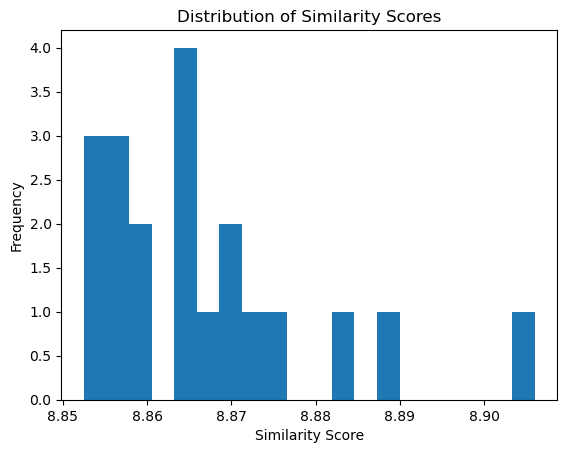

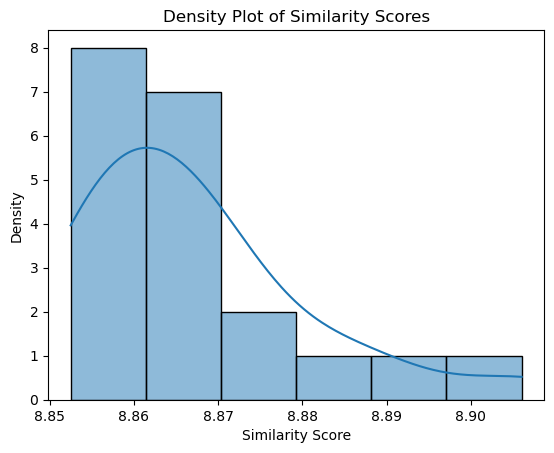

In [29]:
# Calculating Mean Similarity Score with respect to recommendations
MeanSimilarity = TopRecommendations['Similarity3'].mean()
print(f"Mean Similarity Score: {MeanSimilarity}")

# Displaying a histogram of similarity scores
Plot.hist(TopRecommendations['Similarity3'], bins=20)
Plot.xlabel('Similarity Score')
Plot.ylabel('Frequency')
Plot.title('Distribution of Similarity Scores')
Plot.show()

# Displaying a histogram of Density of similarity scores with respect to recommendations
sns.histplot(TopRecommendations['Similarity3'], kde=True)
Plot.xlabel('Similarity Score')
Plot.ylabel('Density')
Plot.title('Density Plot of Similarity Scores')
Plot.show()



Results of Implementation of DeBERTa Model With respect to 1000 samples

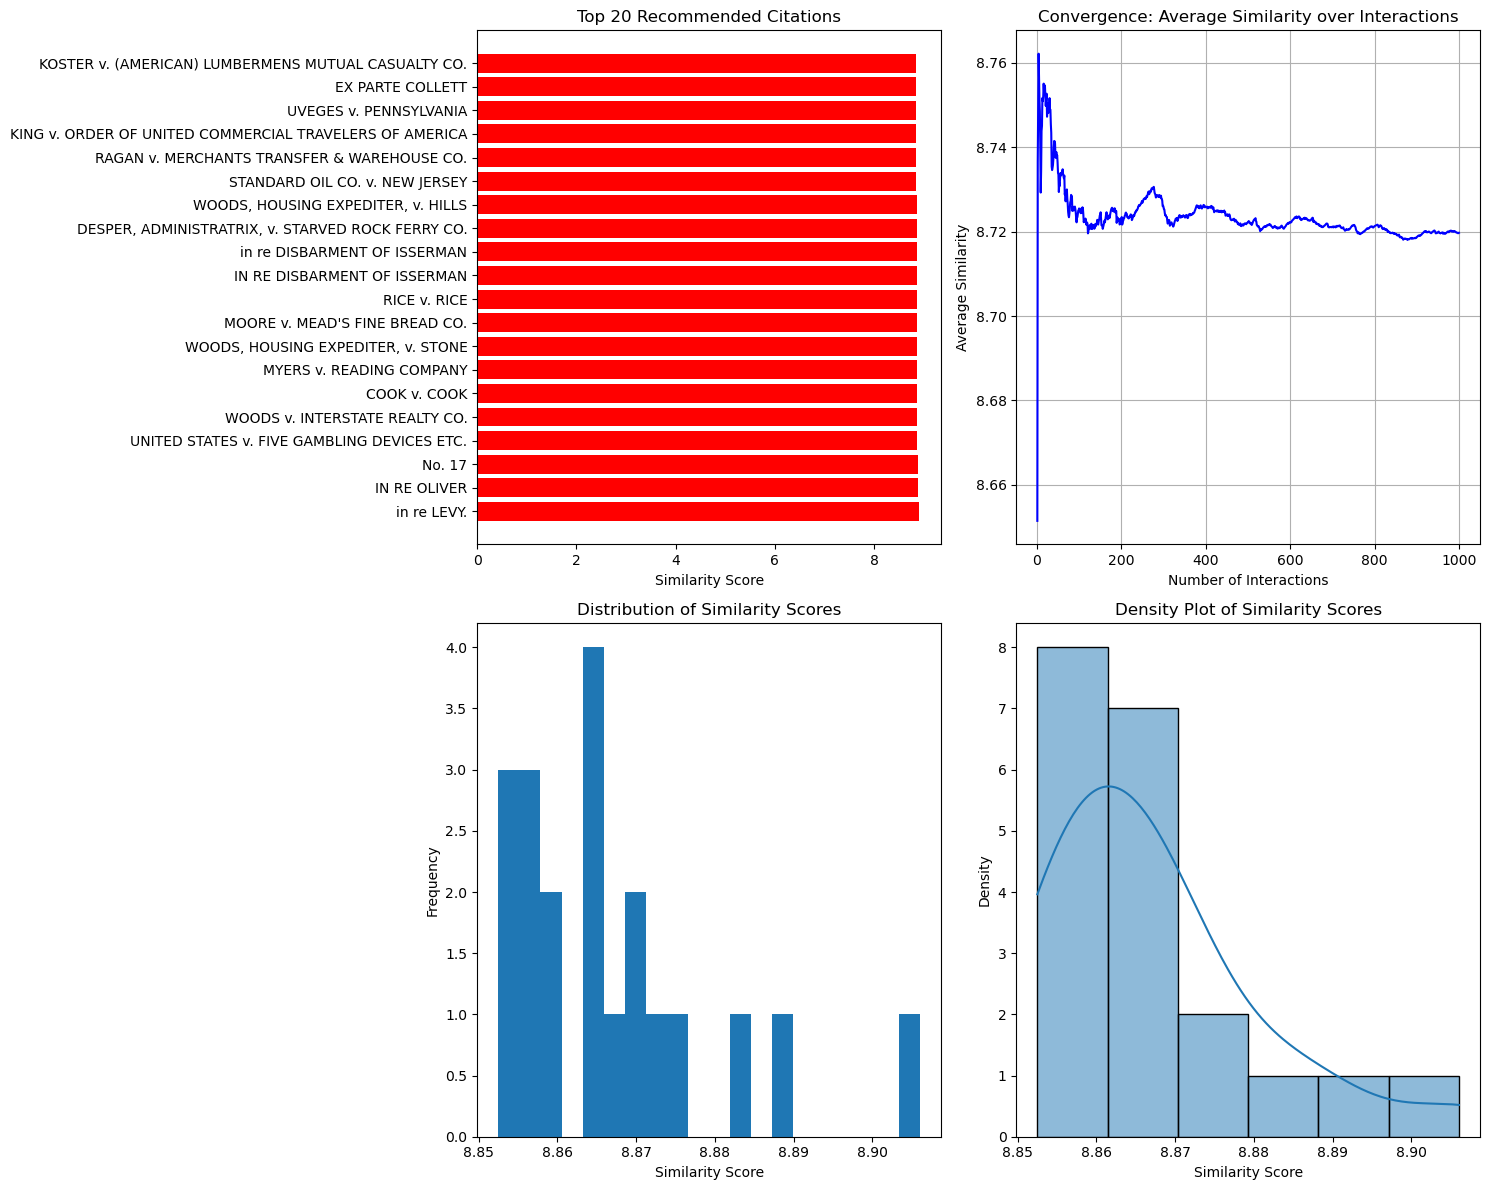

In [30]:

def Plot_Recommendations(Recommendations):
    # Unpacking the tuple of recommendations and average similarities
    TopRecommendations, AvgSimilarities = Recommendations

    # Creating a 2x2 grid of subplots
    fig, axes = Plot.subplots(2, 2, figsize=(15, 12))

    # Plotting the bar plot for recommendations
    Axes1 = axes[0, 0]
    Axes1.barh(TopRecommendations['Legal Text'], TopRecommendations['Similarity3'], color='red')
    Axes1.set_xlabel('Similarity Score')
    Axes1.set_title('Top 20 Recommended Citations')

    # Plotting the convergence metrics
    Axes2 = axes[0, 1]
    interactions = range(1, len(AvgSimilarities) + 1)
    Axes2.plot(interactions, AvgSimilarities, color='blue')
    Axes2.set_title('Convergence: Average Similarity over Interactions')
    Axes2.set_xlabel('Number of Interactions')
    Axes2.set_ylabel('Average Similarity')
    Axes2.grid(True)

    # Plotting the histogram of similarity scores
    Axes3 = axes[1, 0]
    Axes3.hist(TopRecommendations['Similarity3'], bins=20)
    Axes3.set_xlabel('Similarity Score')
    Axes3.set_ylabel('Frequency')
    Axes3.set_title('Distribution of Similarity Scores')

    # Plotting the density plot of similarity scores
    Axes4 = axes[1, 1]
    sns.histplot(TopRecommendations['Similarity3'], kde=True, ax=Axes4)
    Axes4.set_xlabel('Similarity Score')
    Axes4.set_ylabel('Density')
    Axes4.set_title('Density Plot of Similarity Scores')

    # Adjusting layout and display plots
    Plot.tight_layout()
    Plot.show()

InputText = "United States"
TopRecommendations, AvgSimilarities = RecommendLaw(InputText, Data, Embeddings)
Plot_Recommendations((TopRecommendations, AvgSimilarities))

